# CleanLab
cleanlab automatically detects data and label issues in ML datasets.

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import joblib
import ast
import json
import seaborn as sns

from cleanlab.datalab.datalab import Datalab
from cleanlab.classification import CleanLearning

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix


/Users/jessica.ertel/opt/anaconda3/envs/cleanlab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## consider adding visualization of the data here

In [7]:
# df contains x and y train, where each row represents a pixel for 991 plots with 196 pixels each
df = pd.read_csv("../data/cleanlab_demo3.csv")

# import the saved list of plot ids from comb training batches
with open("../data/cleanlab/plot_ids.json", "r") as file:
    id_list = json.load(file)

ceo_plot_ids = np.repeat(id_list, 196)
df['plot_id'] = ceo_plot_ids

In [8]:
# confirm that worked correctly
counts = df.plot_id.value_counts()
error = counts[counts != 196]
len(error)

0

## Find common issues in data
Use cleanlab to detect issues in the dataset (label errors, outliers, near duplicates). An experiment is performed with a Logistic Regression model as a gut check. Then the full assessment is performed with the current plantations model.

### Test with general classifier (gut check)

In [10]:
# generate probabilities
feats = df.loc[:, df.columns!='label']
model = LogisticRegression()
pred_probs = cross_val_predict(estimator=model, 
                               X=feats, 
                               y=df.label, 
                               cv=5, 
                               method="predict_proba")

lab = Datalab(data=df, label_name="label")
lab.find_issues(features=feats, pred_probs=pred_probs)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...


/Users/jessica.ertel/opt/anaconda3/envs/cleanlab/lib/python3.12/site-packages/sklearn/neighbors/_base.py:246: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(



Audit complete. 76728 issues found in the dataset.
Dataset Information: num_examples: 194236, num_classes: 4

Here is a summary of various issues found in your data:

           issue_type  num_issues
                label       47909
       near_duplicate       24670
              outlier        4070
underperforming_group          78
              non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 47909
Overall dataset quality in terms of this issue: 0.7866

Examples representing mos

### Test with trained Catboost Classifier
Trained catboost classifier is loaded and features are filtered to the top 40 feats used in training.

In [16]:
cat = joblib.load("../models/model.joblib")
top_feats = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 18, 20, 22, 24, 25, 32, 34, 42, 50, 52, 60, 64, 65, 70, 71, 73, 74, 75, 76, 77, 81, 85, 89, 90, 93]
feat_cols = ['feature_' + str(i) for i in top_feats]
feats = df.loc[:, df.columns.isin(feat_cols)]

In [17]:
# generate probabilities
pred_probs = cross_val_predict(estimator=cat, 
                               X=feats, 
                               y=df.label, 
                               cv=5, 
                               method="predict_proba")

lab = Datalab(data=df, label_name="label")
lab.find_issues(features=feats, pred_probs=pred_probs)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...


/Users/jessica.ertel/opt/anaconda3/envs/cleanlab/lib/python3.12/site-packages/sklearn/neighbors/_base.py:246: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(



Audit complete. 81510 issues found in the dataset.
Dataset Information: num_examples: 194236, num_classes: 4

Here is a summary of various issues found in your data:

    issue_type  num_issues
         label       35324
near_duplicate       33413
       outlier       12772
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 35324
Overall dataset quality in terms of this issue: 0.8548

Examples representing most severe instances of this issue:
        is_label_issue  label_score

## Analysis of Results
Notes
- A numeric quality score (between 0 and 1) estimating how severe this issue is exhibited in each example from a dataset. Examples with higher scores are less likely to suffer from this issue.

In [9]:
## imports
label_assessment = pd.read_csv(f"../data/cleanlab/label_assessment.csv", index_col="Unnamed: 0")
dup_assessment = pd.read_csv(f"../data/cleanlab/dup_assessment.csv", index_col="Unnamed: 0")
outlier_assessment = pd.read_csv(f"../data/cleanlab/outlier_assessment.csv", index_col="Unnamed: 0")
non_iid_assessment = pd.read_csv(f"../data/cleanlab/non_iid_assessment.csv", index_col="Unnamed: 0")

In [10]:
# filter to problem pixels
label_issues = label_assessment[label_assessment.is_label_issue == True]
dup_issues = dup_assessment[dup_assessment.is_near_duplicate_issue == True]
outlier_issues = outlier_assessment[outlier_assessment.is_outlier_issue == True]
non_iid_issues = non_iid_assessment[non_iid_assessment.is_non_iid_issue == True]

### Label issues

In [11]:
# grab the plot_ids and merge into the results
label_issues['plot_id'] = label_issues.index.map(df.set_index(df.index)['plot_id'])
label_issues['survey'] = label_issues['plot_id'].str[:2]

# identify plots for the top label issues in the report
print(df.iloc[7079][['plot_id']])
print(df.iloc[128128][['plot_id']])
print(df.iloc[7080][['plot_id']])
print(df.iloc[7121][['plot_id']])
print(df.iloc[128161][['plot_id']])

plot_id    08051
Name: 7079, dtype: object
plot_id    21081
Name: 128128, dtype: object
plot_id    08051
Name: 7080, dtype: object
plot_id    08051
Name: 7121, dtype: object
plot_id    21081
Name: 128161, dtype: object


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_26052/4116046334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_issues['plot_id'] = label_issues.index.map(df.set_index(df.index)['plot_id'])
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_26052/4116046334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_issues['survey'] = label_issues['plot_id'].str[:2]


In [12]:
label_issues.head()

,is_label_issue,label_score,given_label,predicted_label,plot_id,survey
7079,True,0.000181,2.0,1.0,08051,08
128128,True,0.000190,1.0,0.0,21081,21
7080,True,0.000191,2.0,1.0,08051,08
7121,True,0.000201,2.0,1.0,08051,08
128161,True,0.000201,1.0,0.0,21081,21


In [13]:
counts = label_issues.plot_id.value_counts()
full_plots = counts[counts == 196]
partial_plots = counts[(counts >= 98) & (counts < 196)]
len(full_plots), len(partial_plots)

(26, 117)

In [14]:
# identify which survey contains the most full plot (26 total) label errors
tmp = label_issues[label_issues.plot_id.isin(full_plots.index)]
tmp.groupby(['survey']).is_label_issue.count()/196

survey
08     1.0
14     1.0
21    23.0
22     1.0
Name: is_label_issue, dtype: float64

In [15]:
# identify which survey contains the most partial plot (117 total) label errors
tmp2 = label_issues[label_issues.plot_id.isin(partial_plots.index)]
tmp2.groupby(['survey']).is_label_issue.count()

survey
08    3075
14    1047
15    1184
19     591
20     892
21    9218
22    1916
Name: is_label_issue, dtype: int64

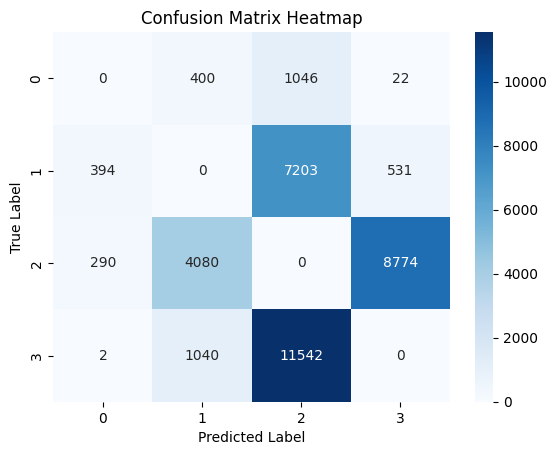

In [16]:
cm = confusion_matrix(label_issues['given_label'], label_issues['predicted_label'], labels=[0.0, 1.0, 2.0, 3.0])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])

# Set labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")

# Show the plot
plt.show()

### Duplication Issues

In [20]:
# grab the plot_ids and merge into the results
dup_issues['plot_id'] = dup_issues.index.map(df.set_index(df.index)['plot_id'])
dup_issues['survey'] = dup_issues['plot_id'].str[:2]
dup_issues.head()

/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_26052/199709975.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dup_issues['plot_id'] = dup_issues.index.map(df.set_index(df.index)['plot_id'])
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_26052/199709975.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dup_issues['survey'] = dup_issues['plot_id'].str[:2]


,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor,plot_id,survey
60532,True,0.000152,[60531 60533 60523 60510 60537 60545 60536 605...,2.121300e-07,14219,14
60531,True,0.000152,[60532 60510 60523 60505 60533 60536 60537 605...,2.121300e-07,14219,14
60522,True,0.000236,[60536 60505 60537 60491 60523 60519 60550 605...,3.297314e-07,14219,14
60536,True,0.000236,[60522 60537 60491 60523 60550 60519 60505 605...,3.297314e-07,14219,14
60537,True,0.000279,[60523 60536 60491 60533 60519 60522 60532 605...,3.896179e-07,14219,14


In [21]:
# create intersection of label and duplicate issues, count plots
dup_label_comb = pd.merge(dup_issues, label_issues, left_index=True, right_index=True, how='inner')
counts_dl = dup_label_comb.plot_id_x.value_counts()
full_plots_dl = counts_dl[counts_dl == 196]
partial_plots_dl = counts_dl[(counts >= 150) & (counts < 196)]
len(full_plots_dl), len(partial_plots_dl)

(0, 39)

In [22]:
partial_plots_dl

plot_id_x
14213    118
19078     99
19081     97
20023     81
21188     79
15013     74
21149     66
21166     66
21160     57
15031     56
21107     47
21201     46
21195     41
21174     37
08060     36
08098     35
21163     34
14197     29
22008     28
15018     21
21170     14
22037     13
08051     10
21196      8
21208      8
21167      7
21143      7
22001      6
21155      6
22009      5
22046      3
21142      2
15035      2
21184      2
21116      2
21129      2
21203      2
21162      2
21180      1
Name: count, dtype: int64

In [75]:
tmp3 = dup_label_comb[dup_label_comb.plot_id_x.isin(partial_plots_dl.index)]
tmp3.groupby(['survey']).is_label_issue.count()

survey
08     81
14    147
15    153
19    196
20     81
21    536
22     55
Name: is_label_issue, dtype: int64

## Conclusions
- There are 26 entire plots that were flagged with label issues. 23 of these are in CEO survey v21, and the remaining 3 plots are in v08, v14 and v22.
- There are 117 partial plots that were flagged with label issues. The majority of these are also in CEO survey v21, with v08 coming in second.
- As expected, the greatest misclassification takes place between the agroforestry and natural tree class. A considerably higher amount of natural pixels are misclassified as AF than vice versa.
- What threshold should be applied for dropping plots that contain both label AND duplicate issues, since there are no cases where an entire plot meets both criteria? Most of the flagged plots only meet both these criteria for <50% of pixels, so does it make sense to drop the entire thing?
  - There are no full plots (196 pixels) flagged with label AND duplicate issues.
  - There are 76 plots with between 98 - 196 pixels flagged.
  - There are 39 plots with 150-196 pixels flagged.